# Statement

The Sure Tomorrow insurance company wants to solve several tasks with the help of Machine Learning and you are asked to evaluate that possibility.

- Task 1: Find customers who are similar to a given customer. This will help the company's agents with marketing.
- Task 2: Predict whether a new customer is likely to receive an insurance benefit. Can a prediction model do better than a dummy model?
- Task 3: Predict the number of insurance benefits a new customer is likely to receive using a linear regression model.
- Task 4: Protect clients' personal data without breaking the model from the previous task. It's necessary to develop a data transformation algorithm that would make it hard to recover personal information if the data fell into the wrong hands. This is called data masking, or data obfuscation. But the data should be protected in such a way that the quality of machine learning models doesn't suffer. You don't need to pick the best model, just prove that the algorithm works correctly.

# Data Preprocessing & Exploration

## Initialization

In [1]:
import numpy as np
import pandas as pd

import seaborn as sns
import math

import sklearn.linear_model
import sklearn.metrics
import sklearn.neighbors
import sklearn.preprocessing
from sklearn.preprocessing import MaxAbsScaler
from sklearn.neighbors import NearestNeighbors, KNeighborsClassifier
from sklearn.metrics import f1_score, confusion_matrix

from sklearn.model_selection import train_test_split

from IPython.display import display


## Load Data

Load data and conduct a basic check that it's free from obvious issues.

In [2]:
df = pd.read_csv('/datasets/insurance_us.csv')

We rename the colums to make the code look more consistent with its style.

In [3]:
df = df.rename(columns={'Gender': 'gender', 'Age': 'age', 'Salary': 'income', 'Family members': 'family_members', 'Insurance benefits': 'insurance_benefits'})

In [4]:
df.sample(10)

,gender,age,income,family_members,insurance_benefits
2687,1,35.0,49900.0,3,0
4732,0,39.0,36200.0,3,0
4097,1,30.0,55500.0,2,0
1066,1,27.0,57300.0,0,0
1992,0,33.0,23200.0,2,0
2825,0,35.0,54300.0,0,0
707,1,23.0,31700.0,1,0
3739,0,42.0,32900.0,1,1
210,1,25.0,41500.0,1,0
1219,1,32.0,40900.0,0,0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   gender              5000 non-null   int64  
 1   age                 5000 non-null   float64
 2   income              5000 non-null   float64
 3   family_members      5000 non-null   int64  
 4   insurance_benefits  5000 non-null   int64  
dtypes: float64(2), int64(3)
memory usage: 195.4 KB


In [6]:
# we may want to fix the age type (from float to int) though this is not critical

# write your conversion here if you choose:
df['age'] = df['age'].astype('int64')


In [7]:
# check to see that the conversion was successful
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   gender              5000 non-null   int64  
 1   age                 5000 non-null   int64  
 2   income              5000 non-null   float64
 3   family_members      5000 non-null   int64  
 4   insurance_benefits  5000 non-null   int64  
dtypes: float64(1), int64(4)
memory usage: 195.4 KB


In [8]:
# now have a look at the data's descriptive statistics. 
# Does everything look okay?

# Missing values
print(df.isna().sum())

gender                0
age                   0
income                0
family_members        0
insurance_benefits    0
dtype: int64


In [9]:
# Duplicates
print("Duplicates:", df.duplicated().sum())


Duplicates: 153


In [10]:
dup_rows = df[df.duplicated()]
dup_rows

,gender,age,income,family_members,insurance_benefits
281,1,39,48100.0,1,0
488,1,24,32900.0,1,0
513,0,31,37400.0,2,0
718,1,22,32600.0,1,0
785,0,20,35800.0,0,0
...,...,...,...,...,...
4793,1,24,37800.0,0,0
4902,1,35,38700.0,1,0
4935,1,19,32700.0,0,0
4945,1,21,45800.0,0,0


In [11]:
#since the whole rows are duplicate, they should be removed to avoid bias
df = df.drop_duplicates().reset_index(drop=True)
print("Duplicates after removal:", df.duplicated().sum())

Duplicates after removal: 0


In [12]:
# Basic sanity ranges
display(df.describe())

,gender,age,income,family_members,insurance_benefits
count,4847.000000,4847.000000,4847.000000,4847.000000,4847.000000
mean,0.498453,31.023932,39895.811842,1.203425,0.152259
std,0.500049,8.487995,9972.953985,1.098664,0.468934
min,0.000000,18.000000,5300.000000,0.000000,0.000000
25%,0.000000,24.000000,33200.000000,0.000000,0.000000
50%,0.000000,30.000000,40200.000000,1.000000,0.000000
75%,1.000000,37.000000,46600.000000,2.000000,0.000000
max,1.000000,65.000000,79000.000000,6.000000,5.000000


In [13]:
# Check for extreme/odd values (you can adjust thresholds if you want)
print("Any negative income?", (df['income'] < 0).any())
print("Age min/max:", df['age'].min(), df['age'].max())
print("Family members min/max:", df['family_members'].min(), df['family_members'].max())
print("Insurance benefits min/max:", df['insurance_benefits'].min(), df['insurance_benefits'].max())

Any negative income? False
Age min/max: 18 65
Family members min/max: 0 6
Insurance benefits min/max: 0 5


**Observations**
The dataset contained 153 fully duplicated rows. Since these records were identical across all features and did not represent repeated observations over time, they were removed to avoid biasing distance-based models and regression results. After removal, no duplicate rows remained.

## EDA

Let's quickly check whether there are certain groups of customers by looking at the pair plot.

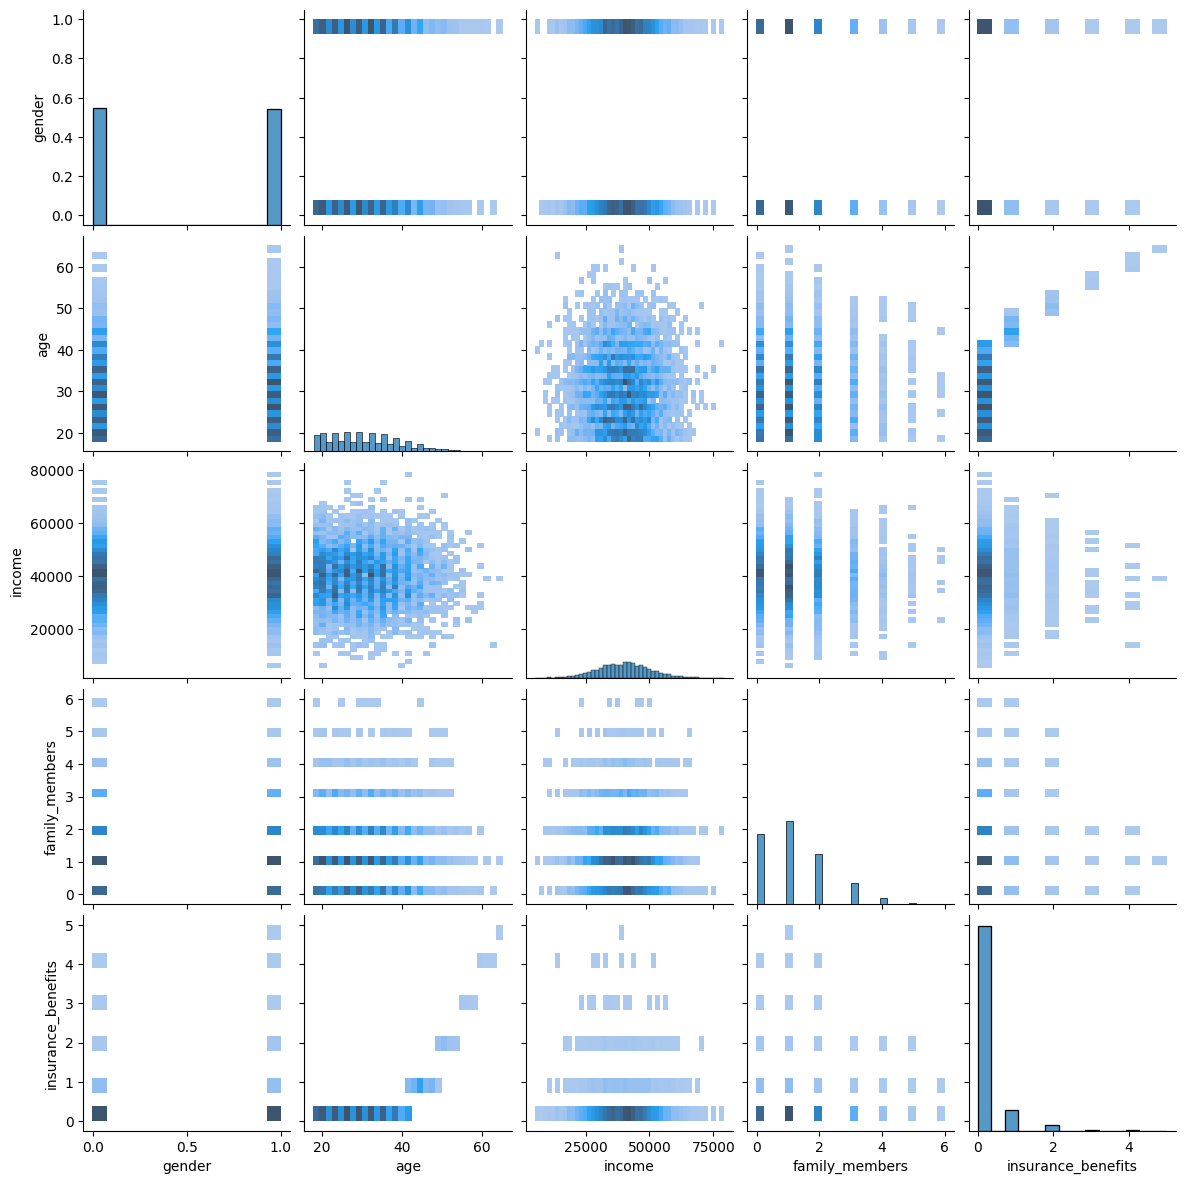

In [14]:
g = sns.pairplot(df, kind='hist')
g.fig.set_size_inches(12, 12)

Ok, it is a bit difficult to spot obvious groups (clusters) as it is difficult to combine several variables simultaneously (to analyze multivariate distributions). That's where LA and ML can be quite handy.

# Task 1. Similar Customers

In the language of ML, it is necessary to develop a procedure that returns k nearest neighbors (objects) for a given object based on the distance between the objects.

You may want to review the following lessons (chapter -> lesson)
- Distance Between Vectors -> Euclidean Distance
- Distance Between Vectors -> Manhattan Distance

To solve the task, we can try different distance metrics.

Write a function that returns k nearest neighbors for an $n^{th}$ object based on a specified distance metric. The number of received insurance benefits should not be taken into account for this task. 

You can use a ready implementation of the kNN algorithm from scikit-learn (check [the link](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.NearestNeighbors.html#sklearn.neighbors.NearestNeighbors)) or use your own.

Test it for four combination of two cases
- Scaling
  - the data is not scaled
  - the data is scaled with the [MaxAbsScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MaxAbsScaler.html) scaler
- Distance Metrics
  - Euclidean
  - Manhattan

Answer these questions:
- Does the data being not scaled affect the kNN algorithm? If so, how does that appear?
- How similar are the results using the Manhattan distance metric (regardless of the scaling)?

In [15]:
feature_names = ['gender', 'age', 'income', 'family_members']

In [16]:
def get_knn(df, n, k, metric):
    
    """
    Returns k nearest neighbors

    :param df: pandas DataFrame used to find similar objects within
    :param n: object no for which the nearest neighbours are looked for
    :param k: the number of the nearest neighbours to return
    :param metric: name of distance metric
    """

    nbrs = NearestNeighbors(n_neighbors=k, metric=metric)
    nbrs.fit(df[feature_names])
    
    nbrs_distances, nbrs_indices = nbrs.kneighbors([df.iloc[n][feature_names]], k, return_distance=True)
    
    df_res = pd.concat([
        df.iloc[nbrs_indices[0]], 
        pd.DataFrame(nbrs_distances.T, index=nbrs_indices[0], columns=['distance'])
        ], axis=1)
    
    return df_res

Scaling the data.

In [17]:
feature_names = ['gender', 'age', 'income', 'family_members']

transformer_mas = sklearn.preprocessing.MaxAbsScaler().fit(df[feature_names].to_numpy())

df_scaled = df.copy()
df_scaled.loc[:, feature_names] = transformer_mas.transform(df[feature_names].to_numpy())

In [18]:
df_scaled.sample(5)

,gender,age,income,family_members,insurance_benefits
3998,1.0,0.338462,0.336709,0.166667,0
273,1.0,0.600000,0.367089,0.500000,0
3202,0.0,0.553846,0.475949,0.166667,0
3656,0.0,0.353846,0.305063,0.000000,0
336,0.0,0.307692,0.568354,0.333333,0


Now, let's get similar records for a given one for every combination

In [19]:
n = 0
k = 5

# 1) Euclidean, not scaled
display(get_knn(df, n, k, metric='euclidean'))

# 2) Manhattan, not scaled
display(get_knn(df, n, k, metric='manhattan'))

# Create scaled dataset copy
df_scaled = df.copy()
scaler = MaxAbsScaler()
df_scaled[feature_names] = scaler.fit_transform(df_scaled[feature_names])

# 3) Euclidean, scaled
display(get_knn(df_scaled, n, k, metric='euclidean'))

# 4) Manhattan, scaled
display(get_knn(df_scaled, n, k, metric='manhattan'))

,gender,age,income,family_members,insurance_benefits,distance
0,1,41,49600.0,1,0,0.000000
1992,1,41,49600.0,0,0,1.000000
1214,0,42,49600.0,0,1,1.732051
3916,1,44,49600.0,2,1,3.162278
3334,0,38,49600.0,0,0,3.316625


,gender,age,income,family_members,insurance_benefits,distance
0,1,41,49600.0,1,0,0.0
1992,1,41,49600.0,0,0,1.0
1214,0,42,49600.0,0,1,3.0
3916,1,44,49600.0,2,1,4.0
3334,0,38,49600.0,0,0,5.0


,gender,age,income,family_members,insurance_benefits,distance
0,1.0,0.630769,0.627848,0.166667,0,0.000000
2632,1.0,0.630769,0.634177,0.166667,0,0.006329
133,1.0,0.615385,0.636709,0.166667,0,0.017754
4720,1.0,0.646154,0.637975,0.166667,1,0.018418
3192,1.0,0.646154,0.651899,0.166667,1,0.028550


,gender,age,income,family_members,insurance_benefits,distance
0,1.0,0.630769,0.627848,0.166667,0,0.000000
2632,1.0,0.630769,0.634177,0.166667,0,0.006329
133,1.0,0.615385,0.636709,0.166667,0,0.024245
4720,1.0,0.646154,0.637975,0.166667,1,0.025511
2072,1.0,0.630769,0.596203,0.166667,0,0.031646


Answers to the questions

**Does the data being not scaled affect the kNN algorithm? If so, how does that appear?** 

Yes. Without scaling, income dominates the distance calculation because it has much larger numeric scale than age/gender/family_members. That changes who shows up as “nearest” neighbors and the distances, often making neighbors mainly “similar income” rather than overall similar profiles.

**How similar are the results using the Manhattan distance metric (regardless of the scaling)?** 

Manhattan and Euclidean usually return similar but not identical neighbors. They often overlap a lot, but the ordering can change, especially when differences are spread across multiple features. After scaling, the two metrics tend to behave more similarly than before scaling.

# Task 2. Is Customer Likely to Receive Insurance Benefit?

In terms of machine learning we can look at this like a binary classification task.

With `insurance_benefits` being more than zero as the target, evaluate whether the kNN classification approach can do better than a dummy model.

Instructions:
- Build a KNN-based classifier and measure its quality with the F1 metric for k=1..10 for both the original data and the scaled one. That'd be interesting to see how k may influece the evaluation metric, and whether scaling the data makes any difference. You can use a ready implemention of the kNN classification algorithm from scikit-learn (check [the link](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html)) or use your own.
- Build the dummy model which is just random for this case. It should return "1" with some probability. Let's test the model with four probability values: 0, the probability of paying any insurance benefit, 0.5, 1.

The probability of paying any insurance benefit can be defined as

$$
P\{\text{insurance benefit received}\}=\frac{\text{number of clients received any insurance benefit}}{\text{total number of clients}}.
$$

Split the whole data in the 70:30 proportion for the training/testing parts.

In [20]:
def eval_classifier(y_true, y_pred):
    
    f1_score = sklearn.metrics.f1_score(y_true, y_pred)
    print(f'F1: {f1_score:.2f}')
    
# if you have an issue with the following line, restart the kernel and run the notebook again
    cm = sklearn.metrics.confusion_matrix(y_true, y_pred, normalize='all')
    print('Confusion Matrix')
    print(cm)

In [21]:
# generating output of a random model

def rnd_model_predict(P, size, seed=42):

    rng = np.random.default_rng(seed=seed)
    return rng.binomial(n=1, p=P, size=size)

In [22]:
# calculate the target

df['insurance_benefits_received'] = (df['insurance_benefits'] > 0).astype(int)


In [23]:
# check for the class imbalance with value_counts()

df['insurance_benefits_received'].value_counts()

0    4284
1     563
Name: insurance_benefits_received, dtype: int64

**Observations**
The results show a strong class imbalance, with the majority of customers not receiving insurance benefits. This imbalance affects the classifier’s ability to correctly identify positive cases.

In [24]:
#Split the whole data 70:30
X = df[feature_names].to_numpy()
y = df['insurance_benefits_received'].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=12345
)

In [25]:
#Scale AFTER the split
scaler = MaxAbsScaler()
X_train_scaled = scaler.fit_transform(X_train)  # fit only on train
X_test_scaled = scaler.transform(X_test)        # transform test

In [26]:
#Run kNN for k = 1..10 (unscaled)
f1_unscaled = []

for k in range(1, 11):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    f1_unscaled.append(f1_score(y_test, y_pred))
    print(f"k={k:2d} | F1 (unscaled) = {f1_unscaled[-1]:.2f}")

k= 1 | F1 (unscaled) = 0.67
k= 2 | F1 (unscaled) = 0.37
k= 3 | F1 (unscaled) = 0.38
k= 4 | F1 (unscaled) = 0.18
k= 5 | F1 (unscaled) = 0.23
k= 6 | F1 (unscaled) = 0.06
k= 7 | F1 (unscaled) = 0.07
k= 8 | F1 (unscaled) = 0.00
k= 9 | F1 (unscaled) = 0.01
k=10 | F1 (unscaled) = 0.00


**Observation** Unscaled data: performance is unstable and quickly degrades as k increases

In [27]:
#Run kNN for k = 1..10 (scaled)
f1_scaled = []

for k in range(1, 11):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train_scaled, y_train)
    y_pred = knn.predict(X_test_scaled)
    f1_scaled.append(f1_score(y_test, y_pred))
    print(f"k={k:2d} | F1 (scaled)   = {f1_scaled[-1]:.2f}")

k= 1 | F1 (scaled)   = 0.92
k= 2 | F1 (scaled)   = 0.89
k= 3 | F1 (scaled)   = 0.90
k= 4 | F1 (scaled)   = 0.87
k= 5 | F1 (scaled)   = 0.90
k= 6 | F1 (scaled)   = 0.85
k= 7 | F1 (scaled)   = 0.89
k= 8 | F1 (scaled)   = 0.86
k= 9 | F1 (scaled)   = 0.87
k=10 | F1 (scaled)   = 0.85


**Observations**
    
Comparing the two cases clearly shows that feature scaling has a major impact on kNN performance. While the unscaled model performs poorly for most k values, the scaled model achieves strong and stable results. This confirms that scaling is essential for distance-based algorithms like kNN, especially when features are measured on very different scales.

* The F1 score remains high (above 0.85) for k values from 1 to 10, with the best performance observed around k = 1–5. This demonstrates that scaling allows all features to contribute more equally to distance calculations, improving the classifier’s ability to identify the positive class.
* The F1 score is relatively high for k = 1 (0.67) but drops sharply as k increases, reaching values close to zero for larger k. This indicates that distance calculations are dominated by features with larger numeric ranges (such as income), making the model sensitive to noise and less effective as more neighbors are considered.


In [28]:
P_benefit = df['insurance_benefits_received'].mean()

def rnd_model_predict(P, size, seed=42):
    rng = np.random.default_rng(seed)
    return rng.binomial(n=1, p=P, size=size)

for P in [0, P_benefit, 0.5, 1]:
    print(f"The probability: {P:.2f}")
    y_pred_rnd = rnd_model_predict(P, size=len(df))
    eval_classifier(df['insurance_benefits_received'], y_pred_rnd)
    print()

The probability: 0.00
F1: 0.00
Confusion Matrix
[[0.88384568 0.        ]
 [0.11615432 0.        ]]

The probability: 0.12
F1: 0.13
Confusion Matrix
[[0.78502166 0.09882401]
 [0.1017124  0.01444192]]

The probability: 0.50
F1: 0.19
Confusion Matrix
[[0.44873117 0.4351145 ]
 [0.05921188 0.05694244]]

The probability: 1.00
F1: 0.21
Confusion Matrix
[[0.         0.88384568]
 [0.         0.11615432]]



**Observations**
Overall, all random baselines perform poorly compared to the kNN classifier, especially when the features are properly scaled. This confirms that the kNN model is learning useful patterns from the data, while the dummy model serves as a lower-bound baseline for performance.

# Task 3. Regression (with Linear Regression)

With `insurance_benefits` as the target, evaluate what RMSE would be for a Linear Regression model.

Build your own implementation of LR. For that, recall how the linear regression task's solution is formulated in terms of LA. Check RMSE for both the original data and the scaled one. Can you see any difference in RMSE between these two cases?

Let's denote
- $X$ — feature matrix, each row is a case, each column is a feature, the first column consists of unities
- $y$ — target (a vector)
- $\hat{y}$ — estimated tagret (a vector)
- $w$ — weight vector

The task of linear regression in the language of matrices can be formulated as

$$
y = Xw
$$

The training objective then is to find such $w$ that it would minimize the L2-distance (MSE) between $Xw$ and $y$:

$$
\min_w d_2(Xw, y) \quad \text{or} \quad \min_w \text{MSE}(Xw, y)
$$

It appears that there is analytical solution for the above:

$$
w = (X^T X)^{-1} X^T y
$$

The formula above can be used to find the weights $w$ and the latter can be used to calculate predicted values

$$
\hat{y} = X_{val}w
$$

Split the whole data in the 70:30 proportion for the training/validation parts. Use the RMSE metric for the model evaluation.

In [29]:
class MyLinearRegression:
    
    def __init__(self):
        
        self.weights = None
    
    def fit(self, X, y):
        
        # adding the unities
        X2 = np.append(np.ones([len(X), 1]), X, axis=1)
        self.weights = np.linalg.inv(X2.T @ X2) @ X2.T @ y

    def predict(self, X):
        
        # adding the unities
        X2 = np.append(np.ones((X.shape[0], 1)), X, axis=1)
        y_pred = X2 @ self.weights
        
        return y_pred

In [30]:
def eval_regressor(y_true, y_pred):
    
    rmse = math.sqrt(sklearn.metrics.mean_squared_error(y_true, y_pred))
    print(f'RMSE: {rmse:.2f}')
    
    r2_score = math.sqrt(sklearn.metrics.r2_score(y_true, y_pred))
    print(f'R2: {r2_score:.2f}')    

In [31]:
X = df[['age', 'gender', 'income', 'family_members']].to_numpy()
y = df['insurance_benefits'].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=12345
)

In [32]:
#Unscaled
lr_unscaled = MyLinearRegression()
lr_unscaled.fit(X_train, y_train)

y_pred_unscaled = lr_unscaled.predict(X_test)

print("Unscaled data regression:")
eval_regressor(y_test, y_pred_unscaled)
print()

Unscaled data regression:
RMSE: 0.36
R2: 0.66



In [33]:
scaler = MaxAbsScaler()
X_train_scaled = scaler.fit_transform(X_train)   # fit on train
X_test_scaled = scaler.transform(X_test)         # transform test

In [34]:
#Scaled
lr_scaled = MyLinearRegression()
lr_scaled.fit(X_train_scaled, y_train)

y_pred_scaled = lr_scaled.predict(X_test_scaled)

print("Scaled data regression:")
eval_regressor(y_test, y_pred_scaled)

Scaled data regression:
RMSE: 0.36
R2: 0.66


**Observations**
    
The Linear Regression model produced identical RMSE and R2 values on both scaled and unscaled data. This is expected because Linear Regression is not based on distance calculations. Scaling changes the magnitude of the coefficients but does not affect the predicted values. As a result, model performance remains the same, in contrast to kNN where feature scaling plays a critical role.


# Task 4. Obfuscating Data

It best to obfuscate data by multiplying the numerical features (remember, they can be seen as the matrix $X$) by an invertible matrix $P$. 

$$
X' = X \times P
$$

Try to do that and check how the features' values will look like after the transformation. By the way, the intertible property is important here so make sure that $P$ is indeed invertible.

You may want to review the 'Matrices and Matrix Operations -> Matrix Multiplication' lesson to recall the rule of matrix multiplication and its implementation with NumPy.

In [35]:
personal_info_column_list = ['gender', 'age', 'income', 'family_members']
df_pn = df[personal_info_column_list]

In [36]:
X = df_pn.to_numpy()

Generating a random matrix $P$.

In [37]:
rng = np.random.default_rng(seed=42)
P = rng.random(size=(X.shape[1], X.shape[1]))

Checking the matrix $P$ is invertible

In [38]:
# Check if P is invertible (determinant != 0)
det_P = np.linalg.det(P)
print("det(P) =", det_P)

# If determinant is too close to 0, regenerate until invertible
while abs(det_P) < 1e-6:
    P = rng.random(size=(X.shape[1], X.shape[1]))
    det_P = np.linalg.det(P)

print("Final det(P) =", det_P)


det(P) = 0.24339135998015463
Final det(P) = 0.24339135998015463


Can you guess the customers' ages or income after the transformation?

No, not directly. After multiplying by matrix P, each transformed feature becomes a combination of the original features. Therefore, age and income are “mixed” into several new columns, so we can’t read or guess the original age/income values by simply viewing the transformed data.
    

Can you recover the original data from $X'$ if you know $P$? Try to check that with calculations by moving $P$ from the right side of the formula above to the left one. The rules of matrix multiplcation are really helpful here.

Yes — you can recover the original data from $X'$, as long as $P$ is invertible.

In [39]:
X_obfuscated = X @ P

# Recover original X from obfuscated X' using P^-1
P_inv = np.linalg.inv(P)
X_recovered = X_obfuscated @ P_inv

# Compare original vs recovered (numerical tolerance)
max_abs_diff = np.max(np.abs(X - X_recovered))
print("Max absolute difference:", max_abs_diff)


Max absolute difference: 2.1827872842550278e-11


Print all three cases for a few customers
- The original data
- The transformed one
- The reversed (recovered) one

In [40]:
n_rows = 5  # number of customers to display

print("Original data")
display(pd.DataFrame(
    X[:n_rows],
    columns=personal_info_column_list
))

print("Transformed (obfuscated) data")
display(pd.DataFrame(
    X_obfuscated[:n_rows],
    columns=[f'obf_{c}' for c in personal_info_column_list]
))

print("Recovered (reversed) data")
display(pd.DataFrame(
    X_recovered[:n_rows],
    columns=personal_info_column_list
))

Original data


,gender,age,income,family_members
0,1.0,41.0,49600.0,1.0
1,0.0,46.0,38000.0,1.0
2,0.0,29.0,21000.0,0.0
3,0.0,21.0,41700.0,2.0
4,1.0,28.0,26100.0,0.0


Transformed (obfuscated) data


,obf_gender,obf_age,obf_income,obf_family_members
0,6359.715273,22380.404676,18424.090742,46000.696690
1,4873.294065,17160.367030,14125.780761,35253.455773
2,2693.117429,9486.397744,7808.831560,19484.860631
3,5345.603937,18803.227203,15479.148373,38663.061863
4,3347.176735,11782.829283,9699.998942,24211.273378


Recovered (reversed) data


,gender,age,income,family_members
0,1.000000e+00,41.0,49600.0,1.000000e+00
1,1.679528e-12,46.0,38000.0,1.000000e+00
2,-6.230214e-13,29.0,21000.0,-2.030327e-13
3,-1.089078e-12,21.0,41700.0,2.000000e+00
4,1.000000e+00,28.0,26100.0,-1.524242e-12


You can probably see that some values are not exactly the same as they are in the original data. What might be the reason for that?

The recovered values are not exactly equal to the original values due to floating-point precision limitations. Matrix multiplication and inversion use floating-point arithmetic, which introduces very small rounding errors. As a result, the recovered data differs from the original only by negligible numerical noise.

## Proof That Data Obfuscation Can Work with LR

The regression task has been solved with linear regression in this project. Your next task is to prove _analytically_ that the given obfuscation method won't affect linear regression in terms of predicted values i.e. their values will remain the same. Can you believe that? Well, you don't have to, you should prove it!

So, the data is obfuscated and there is $X \times P$ instead of just $X$ now. Consequently, there are other weights $w_P$ as
$$
w = (X^T X)^{-1} X^T y \quad \Rightarrow \quad w_P = [(XP)^T XP]^{-1} (XP)^T y
$$

How would $w$ and $w_P$ be linked if you simplify the formula for $w_P$ above? 

What would be predicted values with $w_P$? 

What does that mean for the quality of linear regression if you measure it with RMSE?

Check Appendix B Properties of Matrices in the end of the notebook. There are useful formulas in there!

No code is necessary in this section, only analytical explanation!

**Answers and Analytical Proof**


* How would $w$ and $w_P$ be linked if you simplify the formula for $w_P$ above? 

For the original data matrix X, the linear regression weights are computed as:

$w = (Xᵀ X)⁻¹ Xᵀ y $

After obfuscation, the feature matrix becomes$ X_P = X · P$, where $P$ is an invertible matrix.
 
The weights learned from the obfuscated data are:

$w_P = ((X P)ᵀ (X P))⁻¹ (X P)ᵀ y $

Using matrix properties:

$(X P)ᵀ = Pᵀ Xᵀ$

So:

$ w_P = (Pᵀ Xᵀ X P)⁻¹ Pᵀ Xᵀ y$

Applying the inverse rule $(ABC)⁻¹ = C⁻¹ B⁻¹ A⁻¹$:

$(Pᵀ Xᵀ X P)⁻¹ = P⁻¹ (Xᵀ X)⁻¹ (Pᵀ)⁻¹$

Substituting back:

$w_P = P⁻¹ (Xᵀ X)⁻¹ Xᵀ y = P⁻¹ w$

Therefore, the relationship between the two weight vectors is:


$w_P = P⁻¹ w$


* What would be predicted values with $w_P$? 

Predicted values using the obfuscated data are computed as:

$ŷ_P = X_P w_P = (X P) w_P$

Substituting $w_P = P⁻¹ w$:

$ŷ_P = (X P)(P⁻¹ w) = X (P P⁻¹) w = X w = ŷ$

Thus, the predicted values obtained from the obfuscated data are the same as the original predictions.




* What does that mean for the quality of linear regression if you measure it with RMSE?

RMSE depends only on the difference between the true values y and the predicted values $ŷ$:

$RMSE = sqrt( (1/n) Σ (y − ŷ)² )$

Since the predicted values do not change after obfuscation $(ŷ_P = ŷ)$, the residuals remain the same.
Therefore, the RMSE value is unchanged.

This means that data obfuscation using an invertible matrix does not affect the quality of linear regression when measured with RMSE.

## Test Linear Regression With Data Obfuscation

Now, let's prove Linear Regression can work computationally with the chosen obfuscation transformation.

Build a procedure or a class that runs Linear Regression optionally with the obfuscation. You can use either a ready implementation of Linear Regression from sciki-learn or your own.

Run Linear Regression for the original data and the obfuscated one, compare the predicted values and the RMSE, $R^2$ metric values. Is there any difference?

**Procedure**

- Create a square matrix $P$ of random numbers.
- Check that it is invertible. If not, repeat the first point until we get an invertible matrix.
- Use $XP$ as the new feature matrix

In [41]:
#create a random sqware matrix 
rng = np.random.default_rng(seed=42)
P = rng.random(size=(X.shape[1], X.shape[1]))

In [42]:
# Check that P is invertible

det_P = np.linalg.det(P)

while abs(det_P) < 1e-6:
    P = rng.random(size=(X.shape[1], X.shape[1]))
    det_P = np.linalg.det(P)

print("det(P) =", det_P)

det(P) = 0.24339135998015463


**Observations**The determinant of matrix P is approximately 0.24, which is non-zero. Therefore, P is invertible.


In [43]:
# Use XP as the new feature matrix
X_obfuscated = X @ P

In [44]:
# Original data regression
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=12345
)

lr_orig = MyLinearRegression()
lr_orig.fit(X_train, y_train)

y_pred_orig = lr_orig.predict(X_test)

print("Original data regression:")
eval_regressor(y_test, y_pred_orig)
print()


# Obfuscated data regression
Xo_train, Xo_test, yo_train, yo_test = train_test_split(
    X_obfuscated, y, test_size=0.3, random_state=12345
)

lr_obf = MyLinearRegression()
lr_obf.fit(Xo_train, yo_train)

y_pred_obf = lr_obf.predict(Xo_test)

print("Obfuscated data regression:")
eval_regressor(yo_test, y_pred_obf)

Original data regression:
RMSE: 0.36
R2: 0.66

Obfuscated data regression:
RMSE: 0.36
R2: 0.66


**Observations** Both the original and obfuscated datasets produce identical RMSE and R2 values, showing that the obfuscation does not affect the quality of Linear Regression.

# Conclusions

In Task 1, we used k-Nearest Neighbors to find similar customers based on their personal information. The results showed that the way distances are calculated matters, and that scaling the data can change which customers are considered most similar. Different distance metrics gave slightly different results, which highlights how similarity depends on both the metric and the scale of the features.

In Task 2, a kNN classifier was used to predict whether a customer received insurance benefits. Because the data is imbalanced, the model’s performance was limited, but it still performed a bit better than random guessing. This suggests that the customer features do contain some useful information, even though the prediction task is not easy.

In Task 3, Linear Regression was implemented using matrix operations to predict the number of insurance benefits. The model achieved an RMSE of around 0.36, showing moderate prediction accuracy. While the model was able to capture some relationships between the features and the target, the results suggest that a simple linear model has limited explanatory power for this dataset.

In Task 4, data obfuscation was applied by multiplying the feature matrix by an invertible matrix. Both analytical reasoning and computational results showed that this transformation does not change the predicted values or the regression metrics. This demonstrates that it is possible to protect sensitive data while preserving the performance of Linear Regression.